In [25]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, summary
import torch.optim as optim

c:\Users\dalli\anaconda3\envs\pydl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Data dictionary
tree = {
    'aT': 0.64277,
    'aF': 0.35723,
    'pT': 0.32997,
    'pF': 0.67003,
    'gT': 0.15953,
    'gF': 0.84047,
    'bT': 0.5,
    'bF': 0.5,
    'rT': 0.32841,
    'rF': 0.67159,
    
    'sT': {
        'pFaF': 0.43118, 'pTaF': 0.74591, 'pFaT': 0.8686, 'pTaT': 0.91576,  
    },
    'sF': {
        'pFaF': 1-0.43118, 'pTaF': 1-0.74591, 'pFaT': 1-0.8686, 'pTaT': 1-0.91576
    },
    'yfT': {
        'sF': 0.23119, 'sT': 0.95372
    },
    'yfF': {
        'sF': 1-0.23119, 'sT': 1-0.95372
    },
    'lcT': {
        'gFsF': 0.23146, 'gTsF': 0.86996, 'gFsT': 0.83934, 'gTsT': 0.99351
    },   
    'lcF': {
        'gFsF': 1-0.23146, 'gTsF': 1-0.86996, 'gFsT': 1-0.83934, 'gTsT': 1-0.99351
    },
    'adT': {
        'gF': 0.28956, 'gT': 0.68706
    },
    'adF': {
        'gF': 1-0.28956, 'gT': 1-0.68706
    },
    'cT': {
        'alFlcF': 0.1347, 'alTlcF': 0.64592, 'alFlcT': 0.7664, 'alTlcT': 0.99947
    },
    'cF': {
        'alFlcF': 1-0.1347, 'alTlcF': 1-0.64592, 'alFlcT': 1-0.7664, 'alTlcT': 1-0.99947
    },
    'fT': {
        'lcFcF': 0.35212, 'lcTcF': 0.56514, 'lcFcT': 0.80016, 'lcTcT': 0.89589
    },
    'fF': {
        'lcFcF': 1-0.35212, 'lcTcF': 1-0.56514, 'lcFcT': 1-0.80016, 'lcTcT': 1-0.89589
    },
    'caT': {
        'adFfF': 0.2274, 'adTfF': 0.779, 'adFfT': 0.78861, 'adTfT': 0.97169
    },
    'caF': {
        'adFfF': 1-0.2274, 'adTfF': 1-0.779, 'adFfT': 1-0.78861, 'adTfT': 1-0.97169
    }
}

In [37]:
prob = 0
lct = "lcT"
for sg in tree[lct].keys():
    probLC = tree[lct][sg]
    if "gF" in sg:
        probLC *= tree["gF"]
    else:
        probLC *= tree["gT"]
    probSmoke = 0
    for smoke in ["sF", "sT"]:
        for peer in tree[smoke].keys():
            if "aT" in peer:
                probSmoke += tree[smoke][peer]
    probLC *= probSmoke
print(probLC)

0.3169893006


In [60]:
pars = {"a": [], 
        "yf": ["s"], 
        "p": [],
        "s": ["p", "a"],
        "g": [],
        "lc": ["g", "s"],
        "al": [],
        "c": ["al", "lc"],
        "ad": ["g"],
        "f": ["lc", "c"],
        "ca": ["ad", "f"],
        "b": []
        }

def P(node, val, a, s, p, g):
    parents = pars[node]
    if len(parents) == 0:
        return tree[node + val]
    select = ""
    for parent in parents:
        pval = s if parent == "s" else p if parent == "p" else a if parent == "a" else g
        select += parent + pval
    return tree[node + val][select]
    
    

vals = ["T", "F"]
# a = "T"                 # set anxiety to true
l = "T"                 # set lung cancer to true
for l in vals:
    prob = 0
    for a in vals:
        for s in vals:
            for p in vals:
                for g in vals:
                    dif = P("a", a, a, s, p, g) * \
                            P("p", p, a, s, p, g) * \
                            P("s", s, a, s, p, g) * \
                            P("lc", l, a, s, p, g)
                    prob += dif
                    if dif > 0.1:
                        print(f"P(a={a}, p={p}, s={s}, lc={l}, g={g}) = {round(dif, 3)}")
    print(f"P(lc={l}|do(y=T)) = {round(prob, 3)}")


P(a=T, p=T, s=T, lc=T, g=T) = 0.193
P(a=T, p=T, s=T, lc=T, g=F) = 0.163
P(a=T, p=F, s=T, lc=T, g=T) = 0.372
P(a=T, p=F, s=T, lc=T, g=F) = 0.314
P(a=F, p=F, s=T, lc=T, g=T) = 0.103
P(a=F, p=F, s=F, lc=T, g=T) = 0.118
P(lc=T|do(y=T)) = 1.657
P(a=F, p=F, s=F, lc=F, g=F) = 0.105
P(lc=F|do(y=T)) = 0.343


In [63]:
0.64277 * 0.67003 * 0.8686 * 0.99351

0.3716566558690361

In [ ]:
# def do_calc(target, t_val, given, g_val):
#     vals = ["T", "F"]
#     parents = pars[target]
#     for par in parents:
#         for val in vals:
            

<h1>Explore the LUCAS0 dataset</h1>

Here is the structure of the LUCAS0 dataset:

<img src="images/lucas0_structure.png" alt="Structure of the LUCAS0 dataset." width=600 height=400>

Here are how the features are connected:
* [Anxiety, Smoking] -> [2, 0]
* [Peer Pressure, Smoking] -> [3, 0]
* [Smoking, Yellow Fingers] -> [0, 1]
* [Smoking, Lung Cancer] -> [0, 11]
* [Genetics, Lung Cancer] -> [4, 11]
* [Genetics, Attention Disorder] -> [4, 5]
* [Attention Disorder, Car Accident] -> [5, 7]
* [Lung Cancer, Coughing] -> [11, 10]
* [Lung Cancer, Fatigue] -> [11, 8]
* [Allergy, Coughing] -> [9, 10]
* [Coughing, Fatigue] -> [10, 8]
* [Fatigue, Car Accident] -> [8, 7]

The from nodes are the first element, given by
* [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8],

and the to nodes are the second element, given by
* [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7].

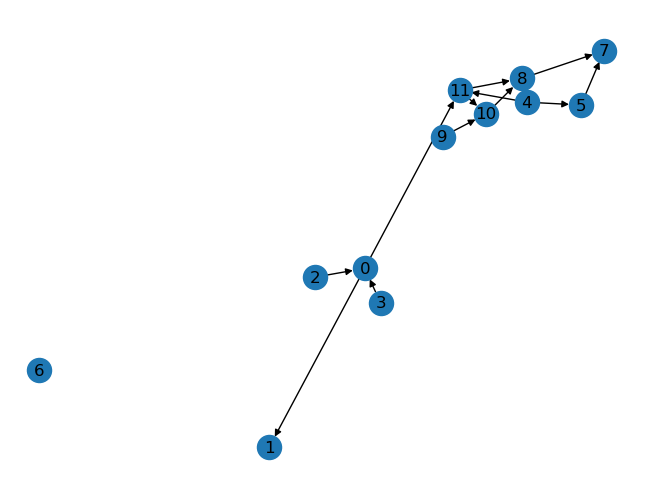

In [26]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values, dtype=torch.float).t()
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values, dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

In [27]:
# Load the dataset
df = pd.read_csv('data/raw/lucas0_train.csv')
df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


In [31]:
df.values.shape

(2000, 11)

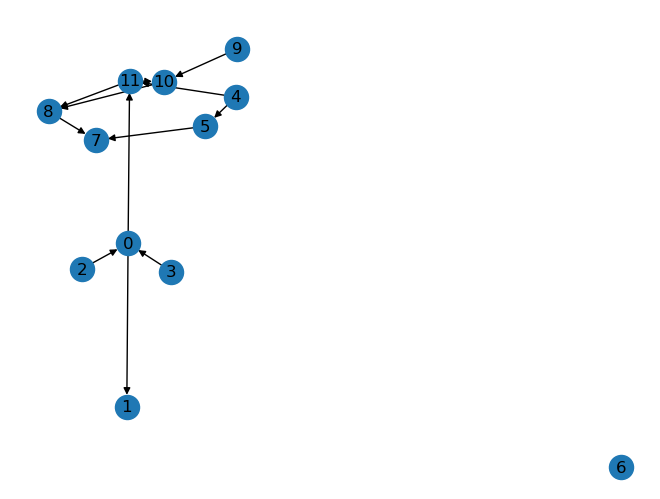

In [47]:
# Your tabular data excluding the target
tabular_data = df.values[:,:-1]
split = int(tabular_data.shape[0] * 0.8)

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features with train and test split
x_train = torch.tensor(tabular_data[:split], dtype=torch.float).t()
x_test = torch.tensor(tabular_data[split:], dtype=torch.float).t()
y_train = torch.tensor(df.Lung_cancer.values[:split], dtype=torch.float)
y_test = torch.tensor(df.Lung_cancer.values[split:], dtype=torch.float)
x = torch.tensor(tabular_data, dtype=torch.float).t()
y = torch.tensor(df.Lung_cancer.values, dtype=torch.float)

# Assuming there are no node labels or edge features in this example
train_data = Data(x=x_train, edge_index=edge_index, y=y_train)
test_data = Data(x=x_test, edge_index=edge_index, y=y_test)
data = Data(x=x, edge_index=edge_index, y=y)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [48]:
print(tabular_data.shape)


(2000, 11)


In [78]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 128)
        self.conv3 = GCNConv(128, 256)
        self.conv4 = GCNConv(256, 512)
        self.conv5 = GCNConv(512, 256)
        self.conv6 = GCNConv(256, 128)
        self.conv7 = GCNConv(128, output_dim)

    def forward(self, x, edge_index):
        # Apply first graph convolution
        x = x.t()
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)    
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training) 
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Apply second graph convolution
        x = self.conv7(x, edge_index)
        return x


# Define model dimensions
print(tabular_data.shape)
input_dim = tabular_data.shape[1]  # Number of input features
output_dim = 1  # Assuming binary classification (e.g., Lung Cancer prediction)
model = GCN(input_dim, output_dim)

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters')





# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

def train_model(model, data, epochs=20):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        # print all the attributes of data
        loss = criterion(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Train the model
train_model(model, train_data, epochs=200)

(2000, 11)
The model has 338049 parameters
Epoch 0, Loss: 0.657102108001709
Epoch 10, Loss: 0.5269066691398621
Epoch 20, Loss: 0.4840378165245056
Epoch 30, Loss: 0.446254163980484
Epoch 40, Loss: 0.4112764596939087
Epoch 50, Loss: 0.4048287868499756
Epoch 60, Loss: 0.40685558319091797
Epoch 70, Loss: 0.40306803584098816
Epoch 80, Loss: 0.379738450050354
Epoch 90, Loss: 0.38833317160606384
Epoch 100, Loss: 0.38396167755126953
Epoch 110, Loss: 0.3759332001209259
Epoch 120, Loss: 0.3783528208732605
Epoch 130, Loss: 0.3743881285190582
Epoch 140, Loss: 0.3718295991420746
Epoch 150, Loss: 0.36014649271965027
Epoch 160, Loss: 0.35457614064216614
Epoch 170, Loss: 0.35302048921585083
Epoch 180, Loss: 0.34674426913261414
Epoch 190, Loss: 0.34923937916755676


In [79]:
def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(test_data.x, test_data.edge_index)
        predicted_labels = torch.sigmoid(out.squeeze())  # Sigmoid activation for binary classification
        return predicted_labels

# Make predictions
predictions = predict(model, test_data)
accuracy = ((predictions > 0.5) == test_data.y).sum().item() / test_data.y.shape[0]
print(f'Accuracy: {accuracy}')

Accuracy: 0.855
